In [1]:
import napari
import napari_workflows as nw
from skimage.io import imread
file_name = r'C:/Users/ryans/Desktop/blobs.tif'
blobs = imread(file_name)

In [2]:
from napari_workflows._io_yaml_v1 import load_workflow, save_workflow        
filename = 'workflow from napari.yaml'

loaded_wf = load_workflow(filename)
print(loaded_wf)

Workflow:
Result of Gaussian (scikit-image, nsbatwm) <- (<function gaussian_blur at 0x0000011C1BFA8E50>, 'blobs', 5.0)
Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm) <- (<function threshold_mean at 0x0000011C1BFA8A60>, 'Result of Gaussian (scikit-image, nsbatwm)')



In [3]:
import inspect
import magicgui
from functools import partial
from napari_tools_menu import make_gui
from inspect import Signature, signature
from functools import partial


def signature_w_kwargs_from_function(function, arg_vals: list) -> Signature:
    
    # getting the keywords corresponding to the values
    keyword_list = list(signature(function).parameters.keys())

    # creating the kwargs dict
    kw_dict = {}
    for kw, val in zip(keyword_list, arg_vals):
        kw_dict[kw] = val
    kw_dict.pop('image') # we are making an assumption that the input will aways be this
    
    sig = signature(partial(function, **kw_dict))
    
    return sig


In [4]:
roots = loaded_wf.roots()
roots

['blobs']

In [5]:
loaded_wf._tasks.items()

dict_items([('Result of Gaussian (scikit-image, nsbatwm)', (<function gaussian_blur at 0x0000011C1BFA8E50>, 'blobs', 5.0)), ('Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)', (<function threshold_mean at 0x0000011C1BFA8A60>, 'Result of Gaussian (scikit-image, nsbatwm)'))])

In [6]:
def wf_steps_with_root_as_input(workflow):
    roots = loaded_wf.roots()
    wf_step_with_rootinput = []
    for result, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source in roots:
                        wf_step_with_rootinput.append(result)
    return wf_step_with_rootinput

root_functions = wf_steps_with_root_as_input(loaded_wf)     
root_functions


['Result of Gaussian (scikit-image, nsbatwm)']

In [23]:
viewer3 = napari.Viewer()
viewer3.add_image(blobs)


workflow = loaded_wf
layers = viewer3.layers
old_to_new_name_mapping = {}

for i, wf_step_name in enumerate(root_functions):
    func = workflow._tasks[wf_step_name][0]
    args = workflow._tasks[wf_step_name][1:] 
    
    signat = signature_w_kwargs_from_function(func, args)
    func.__signature__ = signat
    widget = make_gui(func, viewer3)
    
    
    viewer3.window.add_dock_widget(widget)
    widget(layers[i].data)
    
    new_wf_step_name = 'Result of ' + func.__name__
    old_to_new_name_mapping[wf_step_name] = new_wf_step_name

C:\Users\ryans\anaconda3\envs\np_workflows_v1\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [19]:
old_to_new_name_mapping

{'Result of Gaussian (scikit-image, nsbatwm)': 'Result of gaussian_blur'}

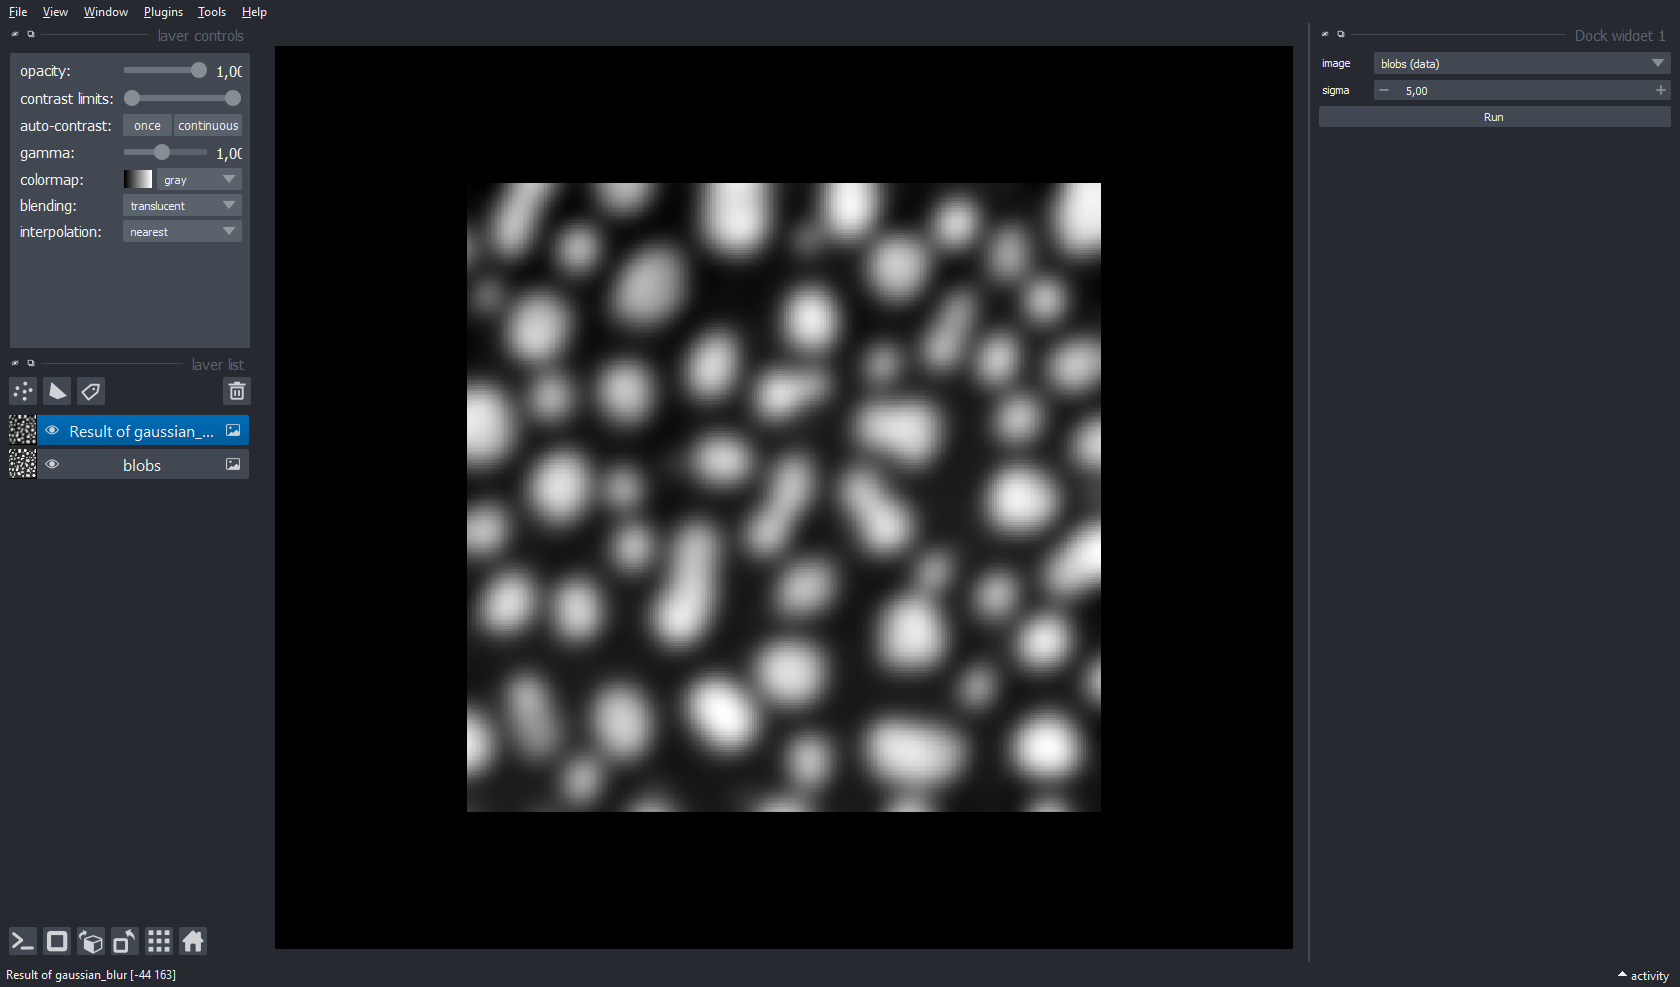

In [11]:
napari.utils.nbscreenshot(viewer3)

In [15]:
wf_manager = nw.WorkflowManager.install(viewer3)
print(wf_manager.workflow)

Workflow:
Result of gaussian_blur <- (<function gaussian_blur at 0x0000011C1BFA8E50>, array([[0.14241512, 0.1394735 , 0.13691215, ..., 0.87450715, 0.87067703,
        0.86561772],
       [0.14424415, 0.14178496, 0.13975406, ..., 0.87968603, 0.87618644,
        0.87154097],
       [0.14615449, 0.14424719, 0.14283962, ..., 0.88433227, 0.88114807,
        0.87690776],
       ...,
       [0.2837892 , 0.27957825, 0.27483018, ..., 0.19772272, 0.19508718,
        0.19345794],
       [0.29217254, 0.28738059, 0.28201462, ..., 0.19880497, 0.19565194,
        0.19364039],
       [0.30039664, 0.29499519, 0.2889847 , ..., 0.19986122, 0.19620111,
        0.19381612]]), 5.0, Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 126.5, 127.5), zoom=2.473492607488812, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(237.88096828980068, 259.29743816135215), scaled=True, size=1, style=<CursorStyle.STANDARD: 's

In [28]:
def direct_follower_of_node(workflow, workflow_step):
    for step, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source == workflow_step:
                        return step

print(direct_follower_of_node(workflow,root_functions[0]))                    

Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)


In [33]:
appendable_roots = root_functions
for root in appendable_roots:
    print('root: ' + str(root))
    followers = [direct_follower_of_node(workflow,root)]
    for follower in followers:
        print(follower)
        # insert check if all the requirements are made
        # if not skip this step and append current node to the node list
        sources = workflow.sources_of(follower)
        if len(sources) == 1: # this means only functions with imge -> image work (for now)
            print('source: ' + str (source))
            
            source = sources[0]
            
            func = workflow._tasks[follower][0]
            args = workflow._tasks[follower][1:] 
            signat = signature_w_kwargs_from_function(func, args)
            func.__signature__ = signat
            widget = make_gui(func, viewer3)
            
            
            widget(layers[old_to_new_name_mapping[source]].data)
            
            
            new_direct_follower = direct_follower_of_node(workflow,follower)
            print('new follower: ' + str(new_direct_follower))
            followers.append(new_direct_follower)

root: Result of Gaussian (scikit-image, nsbatwm)
Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)
source: Result of Gaussian (scikit-image, nsbatwm)
new follower: None
None


0